# Simple Reinforcement Learning with Tensorflow: Part 3 - Model-Based RL

이 iPython notebook은 CartPole 강화 학습 문제를 해결하기 위한 정책과 모델 신경망을 구현하는 것이다.

# 라이브러리 불러오기와 환경 초기화

In [1]:
import numpy as np
import _pickle as pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import gym
env = gym.make('CartPole-v0')

[2017-02-11 18:16:34,078] Making new env: CartPole-v0


# 하이퍼 파라미터 설정

In [3]:
# 하이퍼파라미터 설정
H = 8 # 은닉층 뉴런 수
learning_rate = 1e-2 # 학습률 
gamma = 0.99 # 보상에 대한 할인 인자
decay_rate = 0.99 # RMSProp를 위한 감소 인자
resume = False # 이전 체크포인트로부터 재시작할 것인지 여부

model_bs = 3 # 모델로부터 학습할 때 배치 사이즈
real_bs = 3 # 실제 환경으로부터 학습할 때 배치 사이즈

# 모델 초기화
D = 4 # 입력 차원수

# 정책 신경망 (Policy Network)

In [4]:
# 그래프를 초기호한다
tf.reset_default_graph()

# 입력 상태를 받는다
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
# 8개의 은닉 노드를 만든다
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
# relu 활성화함수
layer1 = tf.nn.relu(tf.matmul(observations,W1))
# 8개의 은닉 노드로 1개의 점수를 낸다
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
# 확률 값을 구한다
probability = tf.nn.sigmoid(score)

# 학습하기 위한 변수들을 모은다
tvars = tf.trainable_variables()
# 가짜 라벨을 받을 곳
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
# 할인된 보상들을 받을 곳
advantages = tf.placeholder(tf.float32,name="reward_signal")
# 최적화 방법 adam
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 그라디언트 업데이트 전에 모아놓을 곳
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

# 각 행동에 대한 확률값이 잘 맞는지를 나타내는 loglik
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
# 위에서 구한 loglik와 할인된 보상을 곱해서 손실로 계산
loss = -tf.reduce_mean(loglik * advantages) 
# 그라디언트를 구한다
newGrads = tf.gradients(loss,tvars)
# 그라디언트를 업데이트함
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

# 모델 신경망 (Model Network)

여기서 우리는 현재 상태와 행동으로부터 다음 상태, 보상, 종료 여부를 예측하는 다층 신경망을 구현한다.

In [5]:
mH = 256 # 모델 은닉층의 노드 수

# 입력 데이터 왜 정책 신경망과는 달리 차원이 5 일까
# 상태와 더블어 행동에 대한 정보도 같이 받기 때문
input_data = tf.placeholder(tf.float32, [None, 5])

# 이전 상태를 받는 부분
previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
# 5개의 입력값을 받아 256개의 값을 반환
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)

# 2번째 히든 레이어 256개를 받아 256개의 히든 노드를 반환
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)

# 상태에 대한 출력값을 내는 부분
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())

# 보상에 대한 출력값을 내는 부분
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

# 종료 상황에 대한 출력값을 내는 부분
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")

# 예측된 상태, 보상, 종료 값
predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

# 실제 상태, 보상, 종료 값을 받음
true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


# 예측 상태를 나타냄
predicted_state = tf.concat(1,[predicted_observation,predicted_reward,predicted_done])

# 상태에 대한 손실
observation_loss = tf.square(true_observation - predicted_observation)

# 보상에 대한 손실
reward_loss = tf.square(true_reward - predicted_reward)

# 종료상황에 대한 손실
done_loss = tf.mul(predicted_done, true_done) + tf.mul(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

# 이 모든 것이 합쳐져서 손실
model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

# 최적화 방법 adam
modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)

#그라디언트 적용하는 부분
updateModel = modelAdam.minimize(model_loss)

# Helper-functions

In [6]:
# 그라디언트 버퍼를 초기화하는 함수
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer
  
# 시간에 대해 할인된 보상을 나타내는 부분
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


# 이전 상태와 행동이 주어졌을 때 새로운 상태를 출력하는 함수
def stepModel(sess, xs, action):
    # 상태와 행동을 하나로 합친다
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    # 예측 상태를 만든다
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    # 예측 보상 부분을 빼냄
    reward = myPredict[0][:,4]
    # 예측 상태부문
    observation = myPredict[0][:,0:4]
    # 상태의 값을 조정한다.
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    
    # 종료 상태의 평가
    doneP = np.clip(myPredict[0][:,5],0,1)
    
    # 종료 상태 예측이 0.1 넘거나, 상태의 갯수가 300이 넘으면 종료로 봄
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

# 정책과 모델을 학습하기

In [7]:
# 상태, 보상, 가짜 라벨, 종료상태를 저장
xs,drs,ys,ds = [],[],[],[]

# 보상을 기록
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1

# 변수를 초기화함
init = tf.global_variables_initializer()

# 초기에 배치 사이즈는 실제 환경으로 한다.
batch_size = real_bs

# 상태에 대해서 모델을 사용할지 여부 True 면 모델의 상태를 사용
drawFromModel = False

# 모델을 학습할지 말지 여부
trainTheModel = True # Whether to train the model

# 정책을 학습할지 말지의 여부
# 처음엔 정책을 학습하지 않는다.
trainThePolicy = False

# 스위치 포인트
switch_point = 1

# 텐서플로 켜기
with tf.Session() as sess:
    # 에이전트는 표시하지 않음
    rendering = False
    
    # 변수를 초기화함
    sess.run(init)
    
    # 상태를 초기화함
    observation = env.reset()
    x = observation
    
    # 그라디언트 버퍼를 만들고 초기화
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    # 5000번 동안 반복
    while episode_number <= 5000:
        # 퍼포먼스가 괜찮아 지면 환경을 표시
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
        
        # 텐서플로가 다룰 수 있게 상태를 조정
        x = np.reshape(observation,[1,4])
        
        # 행동에 대한 확률값을 만든다.
        tfprob = sess.run(probability,feed_dict={observations: x})
        
        # 확률보다 작으면 1 번째의 행동을
        # 확률보다 크면 0 번째의 행동을 함
        action = 1 if np.random.uniform() < tfprob else 0

        # 오류역전파를 위해 중간 상태 기록
        xs.append(x) 
        
        # 가짜 라벨을 기록
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # 실제 상태를 이용할지, 모델의 상태를 이용할지를 결정한 후
        # 다음 상태, 보상, 종료 여부를 나타냄
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
        
        # 총 보상의 합
        reward_sum += reward
        
        # 종료 여부 기록
        ds.append(done*1)
        
        # 보상 기록
        drs.append(reward)

        # 만약 끝났다면
        if done: 
            
            #만약 모델에서 가져 오지 않았다면, 실제 에피소드 1 증가
            if drawFromModel == False: 
                real_episodes += 1
            # 에피소드 수 증가
            episode_number += 1

            # 학습을 위해 에피소드 상태, 보상, 종료여부, 가짜 라벨을 정렬
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # 에피소드의 상태, 보상, 가짜라벨, 종료를 초기화
            
            # 모델을 학습하기로 한다면
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                # 이전 상태와 행동을 결합함 이렇게 해서 차원이 5가 됨
                state_prevs = np.hstack([state_prevs,actions])
                
                # 다음 상태를 체크
                state_nexts = epx[1:,:]
                # 보상을 체크
                rewards = np.array(epr[1:,:])
                # 종료 여부를 체크
                dones = np.array(epd[1:,:])
                
                # 모델 신경망을 학습하기 위해, 입력값을 합침 (사실 의미없어 보임)
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={previous_state: state_prevs, true_observation: state_nexts,true_done:dones,true_reward:rewards}
                # 손실을 계산하고 다음 상태를 예측함
                loss,pState,_ = sess.run([model_loss,predicted_state,updateModel],feed_dict)
            # 정책 신경망을 학습한다면
            if trainThePolicy == True:
                # 할인된 보상을 계산함
                discounted_epr = discount_rewards(epr).astype('float32')
                # 할인된 보상이 평균은 0이고 분산은 1이 되도록 정규화
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                
                # 손실을 이용해 그라디언트를 계산함
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                
                # 그라디언트가 너무 크다면 학습을 종료함
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                
                # 그라디언트를 더함
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
            
            # 에피소드가 적당히 차면
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                # 그라디언트를 정책망에 적용함
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                
                # 상태를 모델로부터 쓰지 않는다면
                if drawFromModel == False:
                    print ('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    # 200이 넘으면 끝냄
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                 # 100 에피소드를 학습하고 나면, 정책을 모델로부터 학습함
                
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            # 상태를 모델로부터 사용한다면
            if drawFromModel == True:
                # 모델 초기화를 랜덤하게 해줌
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            # 그렇지 않다면 gym 의 초기화함수를 사용함
            else:
                observation = env.reset()
                batch_size = real_bs
                
print (real_episodes)

World Perf: Episode 4.000000. Reward 21.666667. action: 0.000000. mean reward 21.666667.
World Perf: Episode 7.000000. Reward 35.000000. action: 1.000000. mean reward 21.800000.
World Perf: Episode 10.000000. Reward 27.666667. action: 1.000000. mean reward 21.858667.
World Perf: Episode 13.000000. Reward 20.666667. action: 0.000000. mean reward 21.846747.
World Perf: Episode 16.000000. Reward 21.333333. action: 0.000000. mean reward 21.841613.
World Perf: Episode 19.000000. Reward 28.000000. action: 1.000000. mean reward 21.903196.
World Perf: Episode 22.000000. Reward 27.000000. action: 1.000000. mean reward 21.954164.
World Perf: Episode 25.000000. Reward 20.333333. action: 0.000000. mean reward 21.937956.
World Perf: Episode 28.000000. Reward 48.666667. action: 1.000000. mean reward 22.205243.
World Perf: Episode 31.000000. Reward 21.000000. action: 1.000000. mean reward 22.193191.
World Perf: Episode 34.000000. Reward 29.000000. action: 1.000000. mean reward 22.261259.
World Perf: 

# 모델 표현을 확인하기

여기서 우리는 모델일 학습 후에 실제 확경에 근사하게 작동하는지를 설명할 수 있다.  초록색 선은 실제 환경 이고 파란색은 모델 예측을 나타낸다.

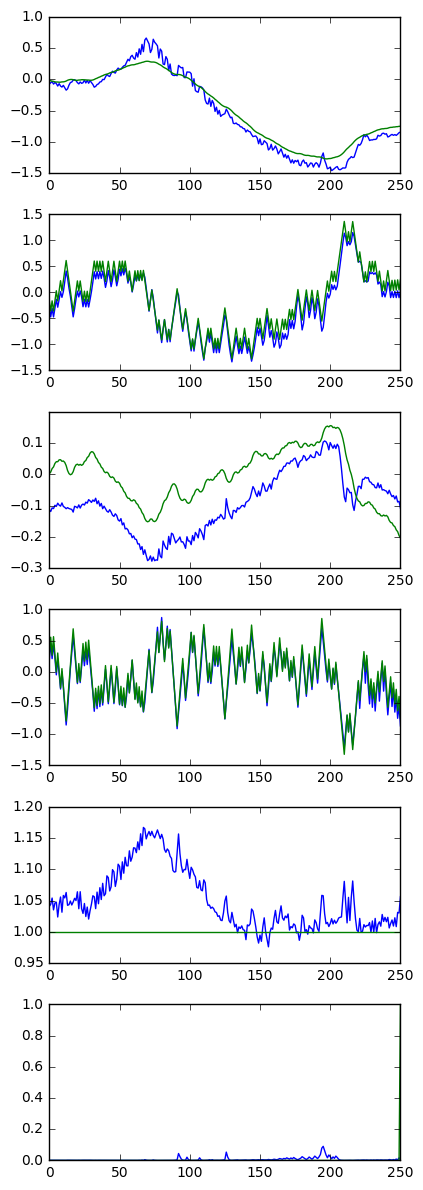

In [8]:
# 그림 크기 지정
plt.figure(figsize=(8, 12))

# 각 예측 (상태, 보상, 종료 여부) 에 대해 그림을 그림
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()